<center>
    COMP4600/5500 - Reinforcement Learning

# Homework 6 - On-policy Control with Approximation

### Due: Monday, November 15th 11:59 pm
    
</center>

Student Name: Kevin Lu

The purpose of this project is to study different properties of Function Approximation with on-policy control methods.  

In [32]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mountain_car import MountainCar
import pygame as pg

## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


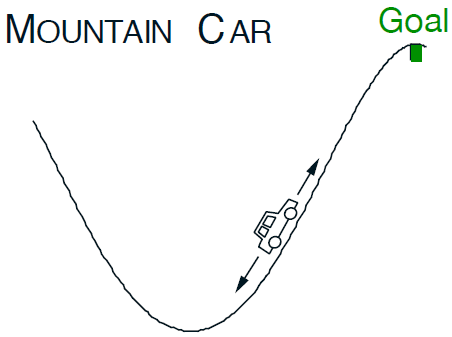


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the $bound$ operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.


## Part I

You have been given a simple implementation of the Mountain Car task. 

1. Your first task is to check and confirm that the given code simulates the above formulae and task description. Then write a function that generates random episodes for this task. You should use the given code for the Mountain Car task. 


In [31]:
WIDTH = 640
HEIGHT = 480
CENTER = 6
TS = 10
bg_color = pg.Color(0,0,0)
agent_color = pg.Color(120,120,0)

In [3]:
car = MountainCar()
xp, vp, r, goal_reached = car.move(-0.5, 0.01, 1)
print(xp,vp,r,goal_reached)

-0.48917684300416925 0.010823156995830741 -1.0 False


In [3]:
def episode(xp, vp):
    car = MountainCar()
    state_history = [(xp,vp)]
    reward_history = []

    for t in range(100):
        a = np.random.choice(car.actions)

        new_xp, new_vp, r, goal_reached = car.move(xp, vp, a)
        reward_history.append(r)
        state_history.append((new_xp,new_vp))
        print("xp = ", new_xp, " vp = ", new_vp, " reward = ", r, " action =", a, " goal reached = ", car.goal_reached)
        xp, vp = new_xp, new_vp
        t += 1

    return state_history

In [9]:
m = episode(-0.5, 0.01)

xp =  -0.48917684300416925  vp =  0.010823156995830741  reward =  -1.0  action = 1  goal reached =  False
xp =  -0.47961139191054886  vp =  0.009565451093620414  reward =  -1.0  action = -1  goal reached =  False
xp =  -0.4713748895320466  vp =  0.00823650237850226  reward =  -1.0  action = -1  goal reached =  False
xp =  -0.46252846590453134  vp =  0.00884642362751525  reward =  -1.0  action = 1  goal reached =  False
xp =  -0.4541375115205651  vp =  0.008390954383966276  reward =  -1.0  action = 0  goal reached =  False
xp =  -0.44526375445437844  vp =  0.008873757066186639  reward =  -1.0  action = 1  goal reached =  False
xp =  -0.4369721171626154  vp =  0.008291637291763049  reward =  -1.0  action = 0  goal reached =  False
xp =  -0.4293228912693031  vp =  0.007649225893312307  reward =  -1.0  action = 0  goal reached =  False
xp =  -0.42137134555450756  vp =  0.007951545714795585  reward =  -1.0  action = 1  goal reached =  False
xp =  -0.41417454333180637  vp =  0.00719680222270

2. Use the Pygame library to develop a simple function that animates a given episode/trajectory. The equation for the mountain is $y = 0.45\sin(3x) + 0.55$. Use a randomly generated episode from the function you developed above and pass it to your animation function, then plot the results.

In [33]:
class Agent:

    def __init__(self, scr, matrix):
        self.w = WIDTH//40
        self.h = HEIGHT//30
        self.x = (5*WIDTH//8)*matrix[0] + WIDTH//1.52
        self.y = -((HEIGHT//4)+(HEIGHT//1.5)*(np.sin(3*matrix[0]) * 0.45 + 0.55)) + HEIGHT//0.86
        self.matrix = matrix
        self.scr = scr
        self.my_rect = pg.Rect((self.x, self.y), (self.w, self.h))

    def show(self, color):
        self.my_rect = pg.Rect((self.x,self.y), (self.w, self.h))
        pg.draw.rect(self.scr, color, self.my_rect)

    def move(self, s):
        pg.time.wait(TS)
        self.x = (5*WIDTH//8)*self.matrix[s] + WIDTH//1.52
        self.y = -((HEIGHT//4)+(HEIGHT//1.5)*(np.sin(3*self.matrix[s]) * 0.45 + 0.55)) + HEIGHT//0.86
        self.show(agent_color)

In [34]:
def animate(m):
    
    pg.init()
    screen = pg.display.set_mode([WIDTH, HEIGHT])
    agent = Agent(screen, m)
    bg = pg.Surface((agent.w, agent.h))
    bg = bg.convert()
    bg.fill(bg_color)
    screen.blit(bg, (agent.x, agent.y))
    clock = pg.time.Clock()
    plotPoints = []
    x = np.arange(0, WIDTH, 0.01)
    y = np.sin(3 * x) * 0.45 + 0.55
    for x0, y0 in zip(x, y):
        plotPoints.append([(5 * WIDTH // 8) * x0, (HEIGHT // 4) + (HEIGHT // 1.5) * y0])
    pg.draw.lines(screen, [0, 0, 255], False, plotPoints, 2)
    pg.display.flip()
    done = False
    run = True
    while run:
        clock.tick(60)
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
            elif done is False:
                for s in range(len(m)):
                    agent.move(s)
                    if s == len(m) - 1:
                        done = True
                        break
                    agent.show(agent_color)
                    pg.display.flip()
                    pg.display.update()
                    screen.blit(bg, (agent.x, agent.y))
        pg.display.flip()
        pg.display.update()
    pg.quit()

In [12]:
def plot(state_history):
    timesteps = []
    for s in range(len(state_history)):
        timesteps.append(s)

    plt.plot(timesteps,state_history)
    plt.xlabel("timesteps")
    plt.ylabel("displacement")
    plt.title("Timesteps vs. Displacement for Random Agent")
    plt.show()

In [24]:
m1 = np.asarray(m)[:, 0]
print(m1)

[-0.5        -0.48917684 -0.47961139 -0.47137489 -0.46252847 -0.45413751
 -0.44526375 -0.43697212 -0.42932289 -0.42137135 -0.41417454 -0.40678376
 -0.40125127 -0.39561592 -0.39091703 -0.38818719 -0.38644522 -0.38570313
 -0.38496601 -0.38523892 -0.38551998 -0.38580727 -0.38709882 -0.38938574
 -0.39165229 -0.39388279 -0.39806179 -0.40416022 -0.41113539 -0.41793812
 -0.42452011 -0.43283429 -0.44282083 -0.45440728 -0.46550896 -0.47804411
 -0.49191985 -0.50503283 -0.51728498 -0.52958448 -0.5408391  -0.55196446
 -0.56387734 -0.57448887 -0.5837202  -0.59250306 -0.60077282 -0.60846892
 -0.61653535 -0.62391376 -0.6305511  -0.6354     -0.63842602 -0.64160777
 -0.64492282 -0.64734791 -0.64986604 -0.65145966 -0.65211767 -0.65183548
 -0.65161507 -0.65045797 -0.64737223 -0.64337937 -0.63750736 -0.62979757
 -0.6223047  -0.6150823  -0.60618236 -0.59566936 -0.58562003 -0.57510822
 -0.56521162 -0.55400374 -0.54256814 -0.53099034 -0.52035712 -0.5087482
 -0.49625063 -0.48295793 -0.46996929 -0.45638114 -0.

In [29]:
#if i run this it will force me to restart the kernel cause the quit method won't work in notebook
animate(m1)

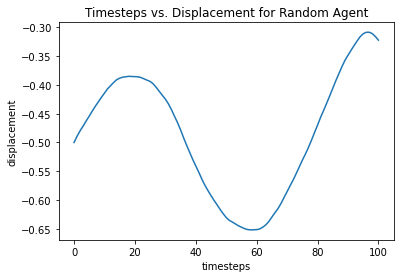

In [30]:
plot(np.asarray(m)[:, 0])

## Part II

Develop a function approximation procedure based on either **Polynomials** or **Fourier basis** (recommended). Given the current $\bar{w}$, the developed function approximation method should return the value for each specific state.

In [36]:
def fourier(tuple):

    states = np.asarray(tuple)
    fourier_x = np.interp(states[0], (-1.2, 0.5), (0, 1))
    fourier_v = np.interp(states[1], (-0.07, 0.07), (0, 1))

    states = (fourier_x, fourier_v)

    order_approx1 = [0, 1, 2, 3]
    order_approx2 = [0, 1, 2, 3]
    c = [[o1,o2] for o1 in order_approx1 for o2 in order_approx2]

    x = np.cos(np.pi * np.matmul(c,states))

    return c,x

## Part III (COMP5500)

1. Implement the **Episodic Semi-gradient $n$-step SARSA** (pp. 247).

In [35]:
def epsilon_greedy(e,q):

    p = np.random.random()
    car = MountainCar()

    if p > e:
        #next_action = np.argmax(q) - 1
        next_action = np.random.choice(np.flatnonzero(q == q.max())) - 1

    else:
        next_action = np.random.choice(car.actions)

    return next_action

In [22]:
def n_step_sarsa(n,alpha):

    episodes = 50

    #alpha = 0.0001
    e = 0.05
    gamma = 0.99
    log_total_episodes = []

    car = MountainCar()
    actions = car.actions
    x_0 = np.random.uniform(low=-0.6, high=-0.4)

    start = (x_0, 0)
    c, x = fourier(start)

    w = np.random.random((len(c), len(actions)))
    q = np.matmul(np.transpose(w), x)

    for episodes in range(episodes):

        car = MountainCar()
        actions = car.actions

        x_0 = np.random.uniform(low=-0.6, high=-0.4)
        start = (x_0, 0)

        state_history = []
        action_history = []
        reward_history = []

        state_history.append(start)
        a = epsilon_greedy(e,q)

        state_update = np.zeros((2,2))
        action_update = np.zeros(2)

        state_update[0][0], state_update[0][1] = start[0], start[1]
        action_update[0] = a
        t = np.inf
        timestep = 0
        s = start

        while True:

            if timestep < t:
                xp, vp, reward, goal_reached = car.move(s[0],s[1],a)
                state_history.append((xp,vp))
                reward_history.append(reward)

                if goal_reached is True:
                    t = timestep + 1

                else:
                    next_a = epsilon_greedy(e,q)
                    action_history.append(next_a)

            if timestep % n == n-1:
                state_update[1] = (xp, vp)
                action_update[1] = a

            tau = timestep - n + 1

            if tau >= 0:
                for i in range(tau + 1, min(tau + n, t)+1):
                    if i == len(reward_history)+1:
                        break
                    G = np.sum([(gamma ** (i - tau - 1)) * reward_history[i-1]])

                if tau + n < t:
                    s_tau_n = state_update[1]
                    a_tau_n = action_update[1]
                    c,x = fourier((s_tau_n[0],s_tau_n[1]))
                    q = np.matmul(np.transpose(w), x)
                    G += (gamma**n) * q[actions.index(a_tau_n)]

                s_tau = state_update[0]
                a_tau = int(action_update[0])
                c, x = fourier((s_tau[0], s_tau[1]))
                q = np.matmul(np.transpose(w), x)
                w[:,actions.index(a_tau)] += alpha*(G-q[actions.index(a_tau)]) * x

            s,a = (xp,vp),next_a
            state_update[0],action_update[0] = state_update[1],action_update[1]
            # print(s,timestep,episodes)

            timestep += 1
            
            if tau == t - 1 or goal_reached is True:
                break

        log_total_episodes.append(timestep)

    return log_total_episodes

2. Use the algorithm to learn the Mountain Car task with $n \in \{1, 8, 16\}$. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

In [25]:
def sarsa_runs(runs,n,alpha):
    
    episodes = 50
    
    result =np.zeros((runs,episodes))
    
    for i in range(runs):
        result[i,:] = np.asarray(n_step_sarsa(n,alpha))
        print(i)
    
    return result

In [15]:
def plot_n_sarsa(result1, result2, result3):
    
    episodes = []

    for i in range(50):
        episodes.append(i)

    plt.plot(episodes, np.mean(result1, axis=0), label = "n = 1, a = 0.0625")
    plt.plot(episodes, np.mean(result2, axis=0), label = "n = 8, a = 0.1")
    plt.plot(episodes, np.mean(result3, axis=0), label = "n = 16, a = 0.15")
    plt.yscale('log')
    plt.xlabel("episodes")
    plt.ylabel("log scale")
    plt.title("n-step Sarsa")
    plt.legend()
    plt.show()

In [10]:
#it takes too long to run 500 episodes so I needed to save time, graph may look a bit off
result1 = sarsa_runs(20,1,0.0625)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [28]:
result8 = sarsa_runs(20,8,0.1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [29]:
result16 = sarsa_runs(20,16,0.15)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


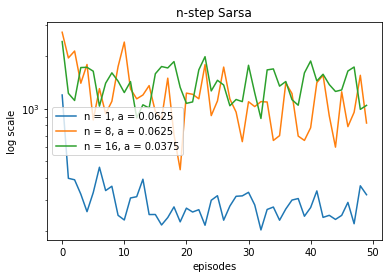

In [30]:
#i already tried several times to run my code and then graph but it keeps crashing
#i looked at the output values for the code and they seem correct and they do what the function is suppose to do
plot_n_sarsa(result1,result8,result16)

3. Show an animation of the task for each $n$.

In [38]:
def n_step_sarsa_animate(n,alpha):

    episodes = 1

    #alpha = 0.0001
    e = 0.05
    gamma = 0.99
    log_total_episodes = []

    car = MountainCar()
    actions = car.actions
    x_0 = np.random.uniform(low=-0.6, high=-0.4)

    start = (x_0, 0)
    c, x = fourier(start)

    w = np.random.random((len(c), len(actions)))
    q = np.matmul(np.transpose(w), x)

    for episodes in range(episodes):

        car = MountainCar()
        actions = car.actions

        x_0 = np.random.uniform(low=-0.6, high=-0.4)
        start = (x_0, 0)

        state_history = []
        action_history = []
        reward_history = []

        state_history.append(start)
        a = epsilon_greedy(e,q)

        state_update = np.zeros((2,2))
        action_update = np.zeros(2)

        state_update[0][0], state_update[0][1] = start[0], start[1]
        action_update[0] = a
        t = np.inf
        timestep = 0
        s = start

        while True:

            if timestep < t:
                xp, vp, reward, goal_reached = car.move(s[0],s[1],a)
                state_history.append((xp,vp))
                reward_history.append(reward)

                if goal_reached is True:
                    t = timestep + 1

                else:
                    next_a = epsilon_greedy(e,q)
                    action_history.append(next_a)

            if timestep % n == n-1:
                state_update[1] = (xp, vp)
                action_update[1] = a

            tau = timestep - n + 1

            if tau >= 0:
                for i in range(tau + 1, min(tau + n, t)+1):
                    if i == len(reward_history)+1:
                        break
                    G = np.sum([(gamma ** (i - tau - 1)) * reward_history[i-1]])

                if tau + n < t:
                    s_tau_n = state_update[1]
                    a_tau_n = action_update[1]
                    c,x = fourier((s_tau_n[0],s_tau_n[1]))
                    q = np.matmul(np.transpose(w), x)
                    G += (gamma**n) * q[actions.index(a_tau_n)]

                s_tau = state_update[0]
                a_tau = int(action_update[0])
                c, x = fourier((s_tau[0], s_tau[1]))
                q = np.matmul(np.transpose(w), x)
                w[:,actions.index(a_tau)] += alpha*(G-q[actions.index(a_tau)]) * x

            s,a = (xp,vp),next_a
            state_update[0],action_update[0] = state_update[1],action_update[1]
            # print(s,timestep,episodes)

            timestep += 1
            
            if tau == t - 1 or goal_reached is True:
                break

        log_total_episodes.append(timestep)

    return state_history

In [17]:
#if i run this it will force me to restart the kernel cause the quit method won't work in notebook
a1 = n_step_sarsa_animate(1, 0.0625)
a1 = np.asarray(a1)[:, 0]
animate(a1)

KeyboardInterrupt: 

In [41]:
a8 = n_step_sarsa_animate(8, 0.1)
a8 = np.asarray(a8)[:, 0]
animate(a8)

In [44]:
a16 = n_step_sarsa_animate(16, 0.15)
a16 = np.asarray(a16)[:, 0]
animate(a16)

4. Which value of $n$ results in faster learning? Why?

>Answer According to the book, n = 16 results in the fastest learning since the algorithm has less states to update. If we take total timesteps/n we see that n = 16 has the lowest amount of updates needed. The algorithm is also looking more moves ahead so it will have more information for making a better optimal action. If the n is too high then the accuracy of future rewards (G) would decrease, this is why we cannot make the n = infinity, therefore, there is a trade between the number of the steps needed to optimize the policy.